In [ ]:
# Teeth Segmentation using Unet with MobileNetV2 Backbone
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U keras
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-7j7a4umy
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-7j7a4umy
  Resolved https://github.com/tensorflow/examples.git to commit 4a468da622d8827db09c57a4df1f3bb59d95d621
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1733136619.424038708570368490133280075616484262886170285601-py3-none-any.whl size=301602 sha256=2d209b093fb48383832ecde7283c4231383b922ce41fae540d4d92f3eecebd6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-wr55vtwb/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
   ━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.cast(input_mask, tf.int32) / 255


  return input_image, input_mask

In [ ]:
def process_image(image_path, mask_path):
  input_image_r = tf.io.read_file(image_path)
  input_image_r = tf.image.decode_jpeg(input_image_r, channels=3)
  input_image = tf.image.resize(input_image_r, (128, 128))
  input_mask_r = tf.io.read_file(mask_path)
  input_mask_r = tf.image.decode_jpeg(input_mask_r, channels=3)
  input_mask = tf.image.resize(
    input_mask_r,
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )
  input_mask = tf.math.reduce_max(input_mask, axis=-1, keepdims=True)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
import imageio
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

path = ''
image_path = os.path.join(path, '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/')
mask_path = os.path.join(path, '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Masks/')
image_list_orig = os.listdir(image_path)
image_list = sorted([image_path+i for i in image_list_orig])
mask_list = sorted([mask_path+i for i in image_list_orig])

split = train_test_split(image_list, mask_list,
	test_size=0.85, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]


TRAIN_LENGTH = len(trainImages)
BATCH_SIZE = 16
BUFFER_SIZE = 200
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
TEST_LENGTH = len(testImages)

train_images_tf = tf.convert_to_tensor(trainImages)  # convert list back to tf.Tensor
train_masks_tf = tf.convert_to_tensor(trainMasks)  # convert list back to tf.Tensor

dataset_train  = tf.data.Dataset.from_tensor_slices((train_images_tf, train_masks_tf))  # create t

test_images_tf = tf.convert_to_tensor(testImages)  # convert list back to tf.Tensor
test_masks_tf = tf.convert_to_tensor(testMasks)  # convert list back to tf.Tensor

dataset_test  = tf.data.Dataset.from_tensor_slices((test_images_tf, test_masks_tf))  # create t


train_images = dataset_train.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset_test.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)



#

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

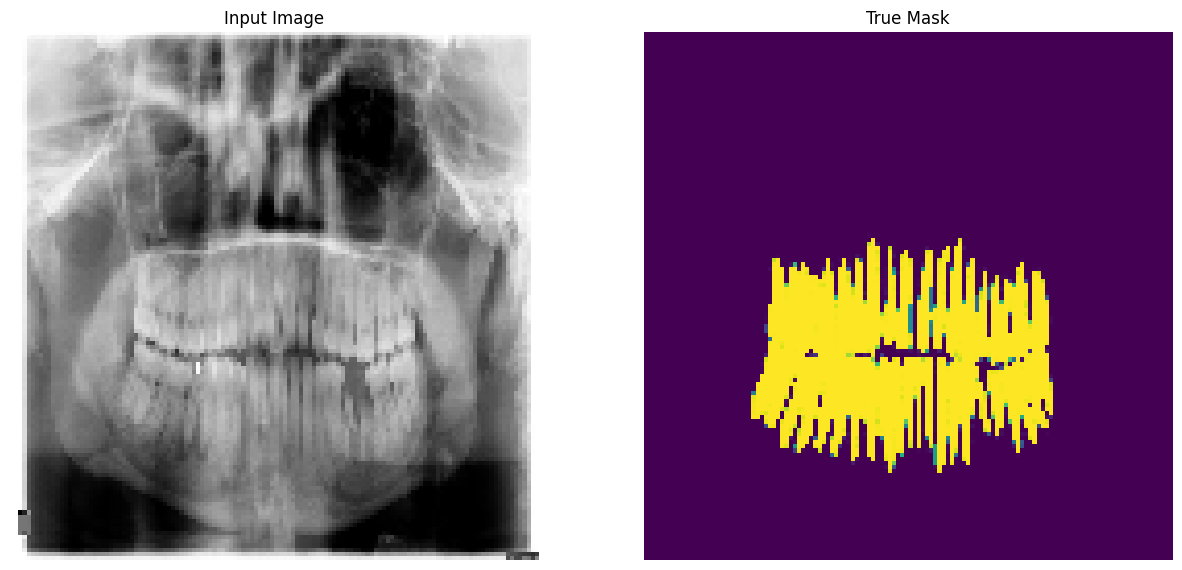

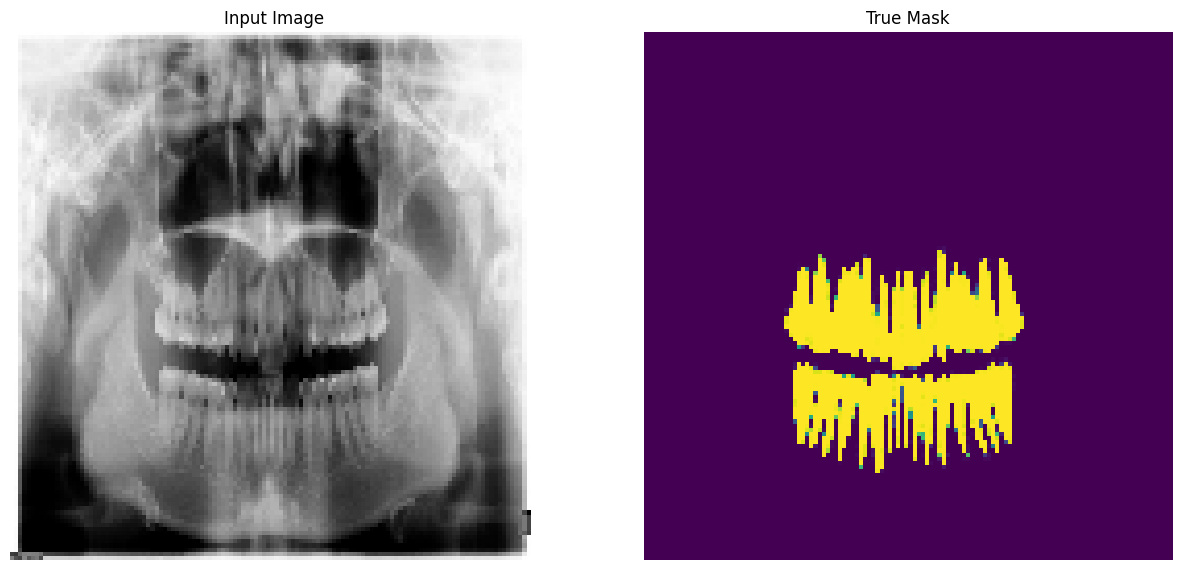

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
def mean_iou(y_true, y_pred):

    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    y_true = tf.squeeze(y_true, axis=-1)

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=(1, 2))

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=(1, 2)) + tf.math.reduce_sum(y_pred, axis=(1, 2))

    union = total - intersection

    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    iou = tf.math.divide_no_nan(intersection, union)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present

    # Compute the mean across the batch axis. Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)

    return mean_iou

In [ ]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', mean_iou])

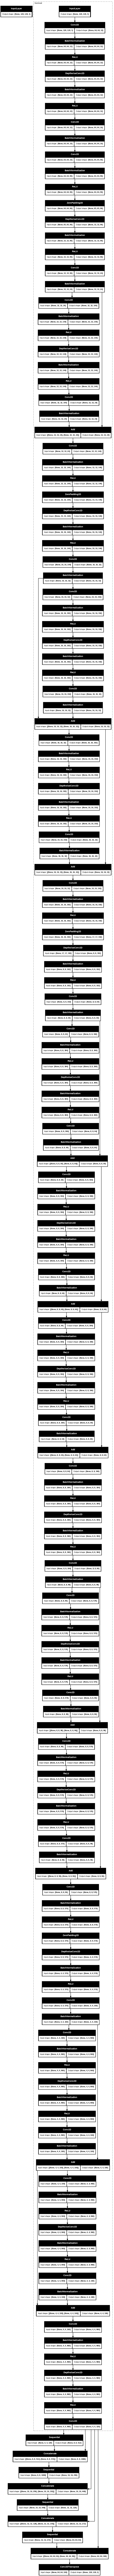

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


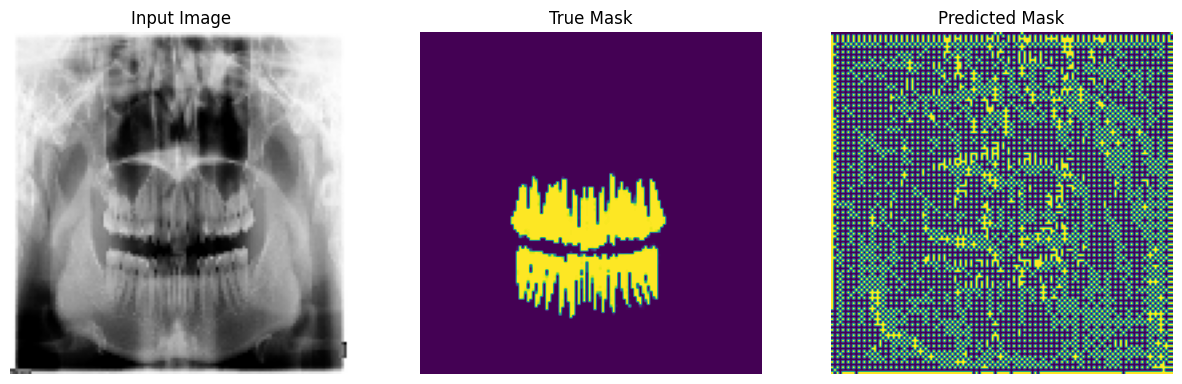

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


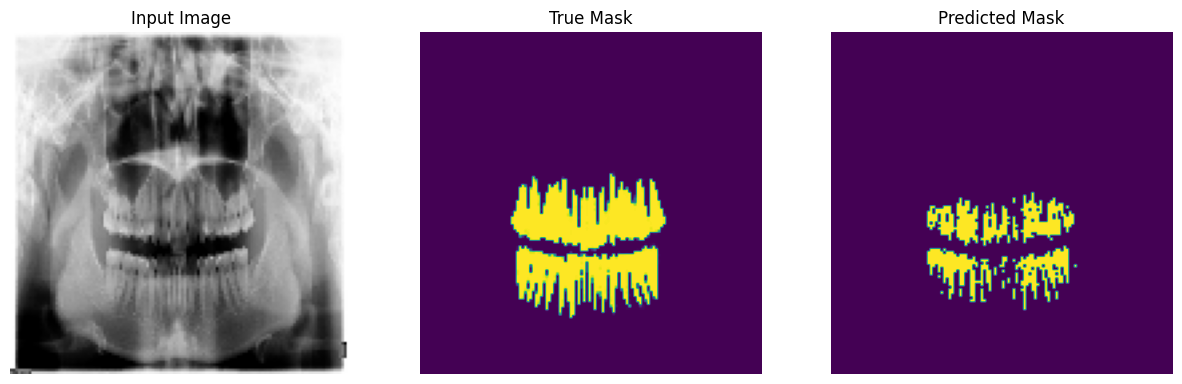


Sample Prediction after epoch 30

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.9424 - loss: 0.0821 - mean_iou: 0.8295 - val_accuracy: 0.9221 - val_loss: 0.1206 - val_mean_iou: 0.7180


In [ ]:
EPOCHS = 30
VAL_SUBSPLITS = 2
VALIDATION_STEPS = TEST_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

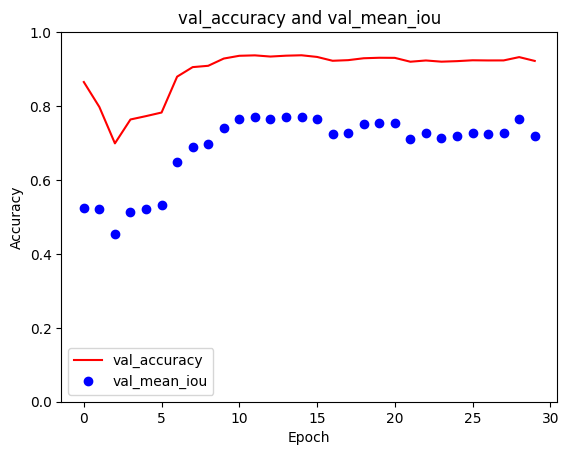

In [ ]:
loss = model_history.history['val_accuracy']
val_loss = model_history.history['val_mean_iou']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='val_accuracy')
plt.plot(model_history.epoch, val_loss, 'bo', label='val_mean_iou')
plt.title('val_accuracy and val_mean_iou')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


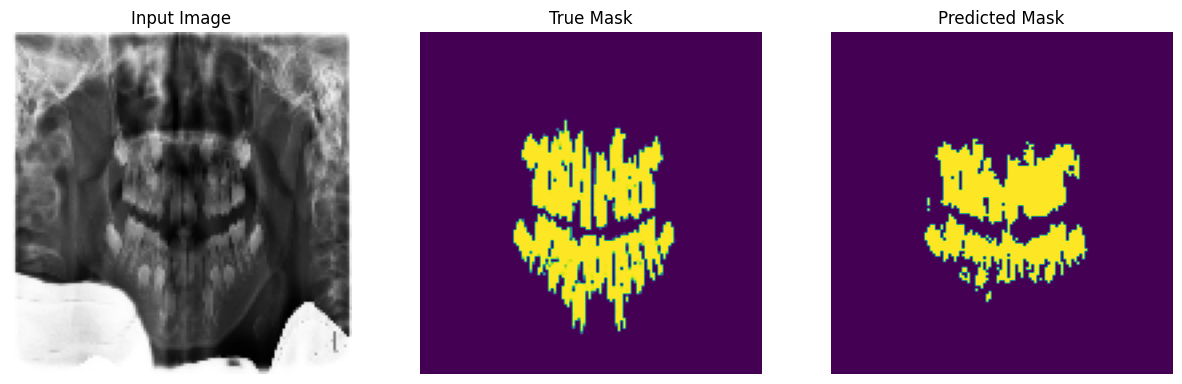

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


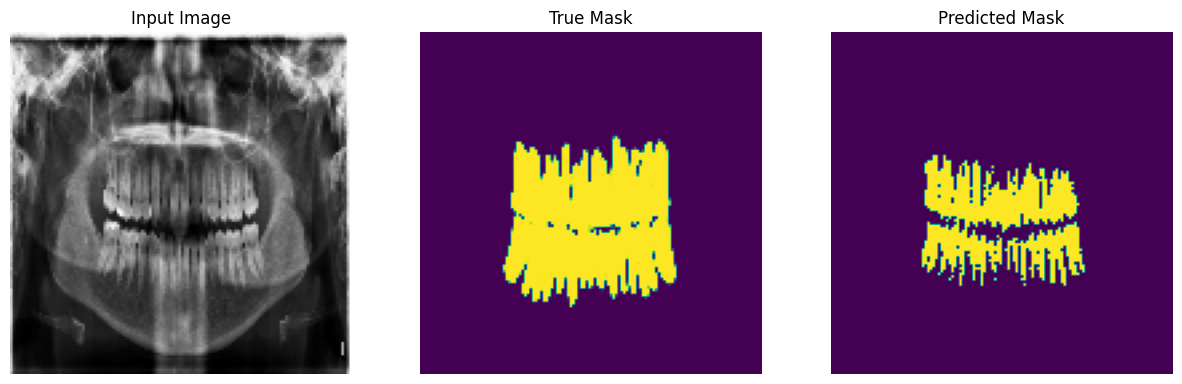

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


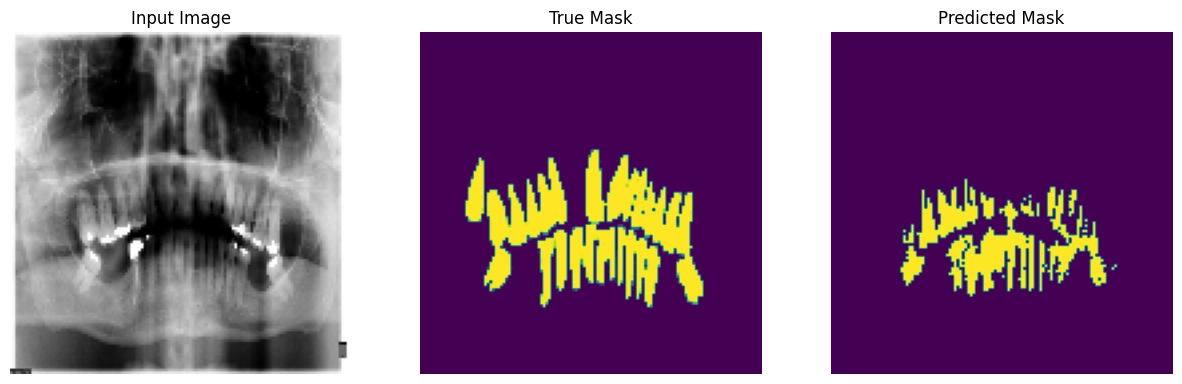

In [ ]:
show_predictions(test_batches, 3)